# 0. Installation
```
pip install git+https://github.com/lapis42/nctrl-ephys
```

# 1. Reading raw data from spikeglx binary file

In [2]:
# Choose a file to read
from ephys.util import finder
fns = finder(multiple=True) # This tries to find the meta files by default
print(fns)
fn = fns[0]
print(fn)

['C:/Users/lapis/Dropbox (HHMI)/data/Y02_20240731_M1_g0/Y02_20240731_M1_g0_imec0\\Y02_20240731_M1_g0_t0.exported.imec0.ap.meta', 'C:/Users/lapis/Dropbox (HHMI)/data/Y02_20240731_M1_g0/Y02_20240731_M1_g0_imec0\\Y02_20240731_M1_g0_t0.imec0.ap.meta']
C:/Users/lapis/Dropbox (HHMI)/data/Y02_20240731_M1_g0/Y02_20240731_M1_g0_imec0\Y02_20240731_M1_g0_t0.exported.imec0.ap.meta


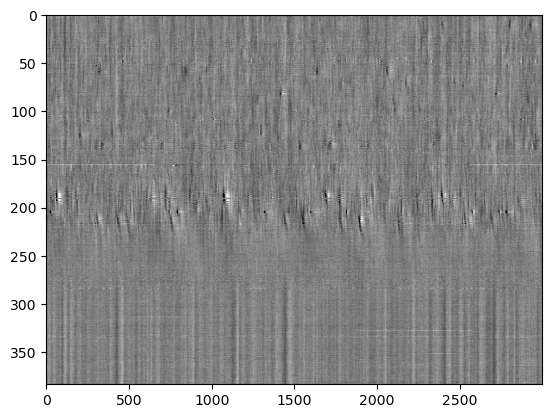

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ephys.spikeglx import read_analog

# read the first 3000 samples (0.1s) of the ap file
data = read_analog(fn, sample_range=(0, 3000))

# normalize the data
data -= np.median(data, axis=0, keepdims=True) # by each channel
data -= np.median(data, axis=1, keepdims=True) # by each time point (CAR)

plt.imshow(data.T, aspect='auto', cmap='gray', vmin=-100, vmax=100)
plt.show()

# 2. Reading digital signals to extract trial-related data

In [8]:
# Reading sync signal from spikeglx binary ap file
from ephys.spikeglx import read_digital
sync_imec = read_digital(fn)
sync_imec

,time,time_frame,chan,type
0,0.152534,4576,6,0
1,0.652536,19576,6,1
2,1.152538,34576,6,0
3,1.652540,49576,6,1
4,2.152542,64576,6,0
...,...,...,...,...
809,404.652850,12139534,6,1
810,405.152852,12154534,6,0
811,405.652854,12169534,6,1
812,406.152856,12184534,6,0


In [12]:
# Read digital signal from spikeglx binary ni file
from ephys.util import finder
from ephys.spikeglx import read_digital

digital_ni = read_digital(finder())
digital_ni

,time,sample,chan,type
0,0.152496,9531,0,0
1,0.652494,40781,0,1
2,1.152509,72032,0,0
3,1.652508,103282,0,1
4,2.152506,134532,0,0
...,...,...,...,...
1217,404.652765,25290864,0,1
1218,405.152763,25322114,0,0
1219,405.652762,25353364,0,1
1220,406.152777,25384615,0,0


In [36]:
# Parsing digital signal from ni file
# This part depends on the specific setup of your NI connection
sync_ni = digital_ni.query("chan == 0")
time_start = digital_ni.query("chan == 1 and type == 1").time.values
time_choice = digital_ni.query("chan == 1 and type == 0").time.values
time_end = digital_ni.query("chan == 2 and type == 1").time.values
time_left = digital_ni.query("chan == 3 and type == 1").time.values
time_right = digital_ni.query("chan == 4 and type == 1").time.values

# extract trialtype
time_trials = np.concatenate((time_left, time_right))
trial_type = np.concatenate((np.zeros(len(time_left)), np.ones(len(time_right))))
trial_type = trial_type[np.argsort(time_trials)]
time_trials = np.sort(time_trials)

print(f"len(time_start): {len(time_start)}" )
print(f"len(time_choice): {len(time_choice)}")
print(f"len(time_end): {len(time_end)}")
print(f"len(time_left): {len(time_left)}")
print(f"len(time_right): {len(time_right)}")
print(f"len(trial_type): {len(trial_type)}")
print(f"len(time_trials): {len(time_trials)}")

len(time_start): 21
len(time_choice): 21
len(time_end): 61
len(time_left): 61
len(time_right): 25
len(trial_type): 86
len(time_trials): 86


Length of sync pulses (imec): 814
Length of sync pulses (ni): 814
Correlation between sync signals: 0.9999999999999956


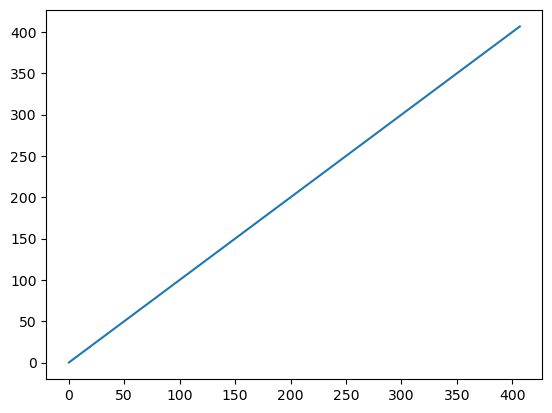

In [19]:
assert(len(sync_imec) == len(sync_ni))
print(f"Length of sync pulses (imec): {len(sync_imec)}")
print(f"Length of sync pulses (ni): {len(sync_ni)}")

# Check if sync singals are well aligned
import matplotlib.pyplot as plt
plt.plot(sync_imec['time'], sync_ni['time'])

# Calculate correlation between sync signals
from scipy.stats import pearsonr
corr, _ = pearsonr(sync_imec['time'], sync_ni['time'])
print(f"Correlation between sync signals: {corr}")

# 3. Load Kilosort data

In [1]:
# loading and parsing kilosort data
from ephys.kilosort import Spike
spike = Spike()

In [2]:
# Save as matlab file
spike.save()

In [5]:
import os
import scipy.io as sio

D = sio.loadmat(os.path.join(spike.path, f'{spike.session}_data.mat'), simplify_cells=True)

In [44]:
time_spike = D['Spike']['time']

# 4. Plotting spike times aligned by time_choice

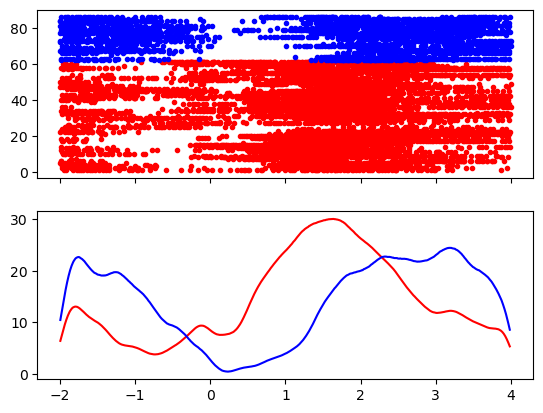

In [46]:
from ephys import spike as sp

i_neuron = 1
raster, psth = sp.plot(time_spike[i_neuron], time_trials, trial_type, window=[-2, 4])

colors = ['r', 'b']
fig, ax = plt.subplots(2, 1, sharex=True)
for i in range(len(raster['x'])):
    ax[0].plot(raster['x'][i], raster['y'][i], '.', color=colors[i])
    ax[1].plot(psth['t'], psth['conv'][i, :], color=colors[i])